In [1]:
import torch                    # Model creation

import torch.nn as nn
import torch.optim as optim

import numpy                    # General purpose math
import matplotlib.pyplot as plt # Plotting

## Creating the Dataset

To demonstrate how logistic regression works, we need to create an exemplary dataset. There are various possibilities, and we will create simple moons dataset using `scikit-learn` `make_moons`, so we can focus more on machine learning part itself.

In [2]:
from sklearn.datasets        import make_moons       # General dataset creation
from sklearn.model_selection import train_test_split # Splitting the dataset into train and test part
from sklearn.preprocessing   import StandardScaler   # Rescaling the dataset, explained down below

In [3]:
# Generate the original dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

To make sure we understand the dataset:
 - `X` contains values of shape `(x, y)`, representing the `x` and `y` coordinates of each point.
 - `Y` contains singular value, either `0` or `1`, representing the class respective sample is part of.

In [4]:
# Split the dataset into train and test - standard approach
# This will split original dataset of 1000 samples into 20% test (i.e. 200 samples), and 80% train (i.e. 800 samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Let's visualize training data! *(This part is not inherent to training the model, but it helps the intuition)*

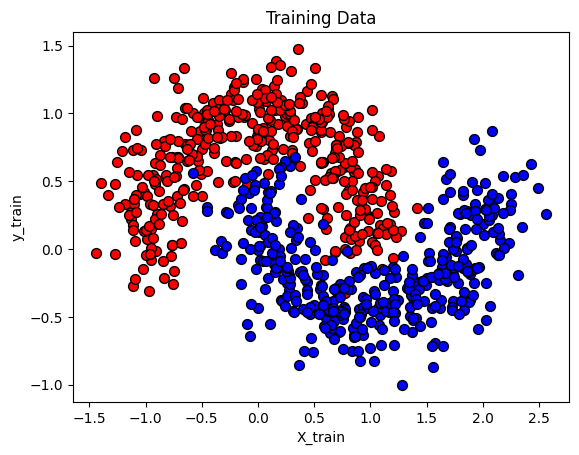

<Figure size 800x600 with 0 Axes>

In [5]:
X_train_class_0 = X_train[y_train == 0] # Get all the training samples whose class, i.e. `y`, equals 0 
X_train_class_1 = X_train[y_train == 1] # Get all the training samples whose class, i.e. `y`, equals 1

# Scatter given samples in two different colors - red for class `0`, and blue for class `1`
plt.scatter(X_train_class_0[:, 0], X_train_class_0[:, 1], color='red',  label="Class 0", edgecolor="k", s=50)
plt.scatter(X_train_class_1[:, 0], X_train_class_1[:, 1], color='blue', label="Class 1", edgecolor="k", s=50)

# General plotting settings
plt.title("Training Data") # Plot title
plt.xlabel("X_train")      # X-axis label
plt.ylabel("y_train")      # Y-axis label
plt.figure(figsize=(8, 6)) # Figure size

plt.show() # Finally, show the plot

This is the data we will be using to train our model.

However, to be able to use them within PyTorch model, we must turn them into `tensors`, in quite intuitive manner:

In [6]:
# Features
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)

# Labels
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

## Model Implementation

In [7]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        """Constructor method
        
        Using inheritance of torch.nn.Module, LogisticRegressionModel is created. 
        This is the standard method for creating various other models too.  
        
        Args:
            input_size  (int): the number of input values
            output_size (int): the number of output values
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size) # Applying standard linear transformation (f(x) = wx + b) 

    def forward(self, X):
        """Forward pass 
    
        Based on current value of "w", calculate the prediction for each value of "X".
        This is basically the point of the model - predicting the right "w".
        
        Args:
            X (torch.Tensor): The values used for making prediction based on current state of "w" and "b"

        Returns:
            out (torch.Tensor): Model evaluation for given input
        """
        out = self.linear(X)     # Function is a simple linear equation: f(x) = w * x + b
        out = torch.sigmoid(out) # Sigmoid activation function is applied
        return out

This is the basic definition of a logistic regression model. We perform a standard `f(x) = wx + b` calculation, then apply a `sigmoid` function to scale the data down.
Let's create a new model:

In [8]:
# We create a model with input size 2, since each entry in `X` has two values
# Our model should return a single value, as the result of calculation
model = LogisticRegressionModel(2, 1)

Model can be trained on a CPU, but also on a GPU (CUDA), which is oftentimes much faster. Let PyTorch prefer the CUDA environment, if possible, and port the model to such device:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/home/lukan123/Desktop/pytorch-algo-impl/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


LogisticRegressionModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

## Training the Model

To be able to even use the data in training, we must port it to the same device as the model. Let's do so:

In [10]:
# Features
X_train = X_train.to(device)
X_test  = X_test.to(device)

# Labels
y_train = y_train.to(device)
y_test  = y_test.to(device)

In binary classification tasks, the standard approach is to use `Binary Cross-Entropy Loss`:

In [11]:
criterion = nn.BCELoss()

Additionally, we can choose which optimizer to use. For the exemplary purposes, we will resort to the popular `Adam`.

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

We will train our model for **1000 epochs**. This means that the model will pass through all the training data **1000 times**.

In [13]:
epochs = 1000

In [14]:
for epoch in range(epochs):
    model.train()

    y_predictions = model(X_train)
    
    # Calculate the loss between the predictions made, and the actual values
    loss = criterion(y_predictions, y_train)

    # Perform a backward pass
    optimizer.zero_grad() # Do not accumulate the gradient
    loss.backward()       # Do a back propagation setp
    optimizer.step()      # Optimize the weights

    # Print the data every 100 epochs
    if epoch % 100 == 0:
        print("Epoch: {}, \tLoss: {}".format(epoch, loss.item()))

Epoch: 0, 	Loss: 0.8470518589019775
Epoch: 100, 	Loss: 0.49165818095207214
Epoch: 200, 	Loss: 0.39148715138435364
Epoch: 300, 	Loss: 0.35092246532440186
Epoch: 400, 	Loss: 0.32834383845329285
Epoch: 500, 	Loss: 0.31385931372642517
Epoch: 600, 	Loss: 0.3041418194770813
Epoch: 700, 	Loss: 0.2975515127182007
Epoch: 800, 	Loss: 0.29306888580322266
Epoch: 900, 	Loss: 0.2900167405605316


This is our **training loss**. It tells us how model adapts to the training data. However, we must also check the **test loss** - how model generalizes on the unseen data. This is how we do so:

In [15]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_test_predictions = model(X_test).round()
    test_accuracy      = (y_test_predictions.eq(y_test).sum().float() / y_test.shape[0]).item()

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 87.50%


## Showing the Model's Decision Boundary

/home/lukan123/Desktop/pytorch-algo-impl/venv/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


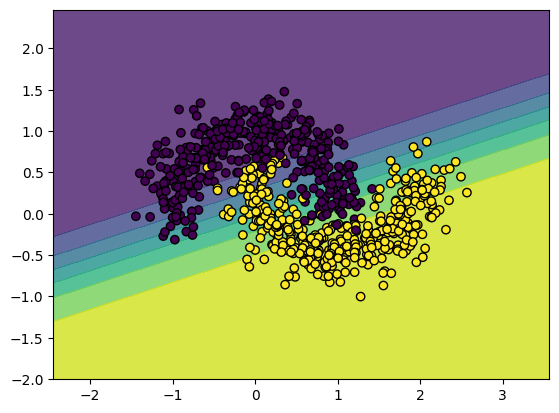

In [16]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.01), torch.arange(y_min, y_max, 0.01))
    grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1).float().to(device)
    
    with torch.no_grad():
        preds = model(grid).cpu().reshape(xx.shape)
        
    plt.contourf(xx, yy, preds, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.show()

plot_decision_boundary(model, X_train.cpu().numpy(), y_train.cpu().numpy())